# Predict Next Purchase

---

This tutorial will walk you through using a historical sales dataset to predict whether or not a customer will **spend more than $500 in the next month**. This is a supervised classification problem.

Data is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/). This is a transnational [data set](https://archive.ics.uci.edu/ml/datasets/online+retail) which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

<font color='red'>WARNING!</font> For this demo to work, you can't use any commits of `featuretools` beyond `ffb8081ca98be59b8e053ebc4e34adeecc9f32ab`. To install a particular version of a Python package from GitHub, you can use the following command. I'm not aware of a way to do this using the Anaconda Navigator GUI.

```
pip install git+https://github.com/Featuretools/featuretools@ffb8081ca98be59b8e053ebc4e34adeecc9f32ab
```

## Contents

---

- [Setup](#Setup)
  - [Imports](#Imports)
  - [Visual Setup](#Visual-Setup)
  - [Functions](#Functions)
  - [Load Data](#Load-Data)
  - [Data Cleaning and Exploration](#Data-Cleaning-and-Exploration)
  - [Empirical Cumulative Distribution Function](#Empirical-Cumulative-Distribution-Function)
- [Prediction Problem](#Prediction-Problem)
- [Making Labels](#Making-Labels)
- [Feature Engineering](#Feature-Engineering)
  - [Featuretools Implementation](#Featuretools-Implementation)
    - [Create an Entity Set](#Create-an-Entity-Set)
    - [Normalize Entities](#Normalize-Entities)
    - [Deep Feature Synthesis](#Deep-Feature-Synthesis)
- [Preliminary Modelling](#Preliminary-Modelling)
- [Compare to Baseline](#Compare-to-Baseline)
- [References](#References)

## Setup

---

### Imports

In [1]:
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.distributions.empirical_distribution import ECDF

### Visual Setup

Below is what I call Jupyter Notebook magic. This code is specific to Jupyter Notebooks, and code like this is prefixed by the `%` symbol.

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

Sure looks pretty, doesn't it?

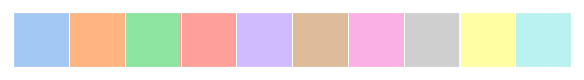

In [4]:
sns.set(palette="pastel")
current_palette = sns.color_palette()
sns.palplot(current_palette)

## Functions

I'm defining a variety of functions that will be used later. For the reader, you can just skip past this section for now.

In [ ]:
def plot_feature_importances(df, n=15, threshold=None):
    """Plots n most important features.
    
    Also plots the cumulative importance i threshold is specified and prints the number of
    features needed to reach threshold cumulative importance. Intended for use with any
    tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature"
                        and "Importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided,
                           no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized
                        column (sums to 1) and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least
          important.
        * A threshold of 0.9 will show the most important features needed to reach 90% of
          cumulative importance.    
    """
    # Sort features with most important at the head.
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance.
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features.
    df.loc[:n, :].plot.barh(
        y = 'importance_normalized', 
        x = 'feature',
        color = 'blue', 
        edgecolor = 'k',
        figsize = (12, 8),
        legend = False
    )

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot.
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance.
        # This is the index (will need to add 1 for the actual number).
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot.
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(
            importance_index + 1,
            100 * threshold
        ))
    
    return df

I wrote out how to do this manually later in the notebook for the 1st model developed. This code makes iterating and testing other models much more concise.

In [ ]:
def get_trained_model(
    model,
    time_period_to_predict,
    feature_matrix,
    verbose=True
):
    # For now, this is just taking the int of the month. We could make this smarter.
    month = time_period_to_predict

    test_labels = feature_matrix.loc[feature_matrix['Month'] == month, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['Month'] < month, 'Label']
    
    # Remember that the training and test set are dependent upon the timeframe.
    x_train = feature_matrix[feature_matrix['time'].dt.month < month].drop(columns = [
        "CustomerID",
        "time",
        "Month",
        "Label",
        "Total"
    ])
    x_test = feature_matrix[feature_matrix['time'].dt.month == month].drop(columns = [
        "CustomerID",
        "time",
        "Month",
        "Label",
        "Total"
    ])
    
    # Impute and scale features.
    pipeline = Pipeline([
        ('imputer', Imputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])
    
    # Fit and transform training and test data.
    transformed_x_train = pipeline.fit_transform(x_train)
    transformed_x_test = pipeline.fit_transform(x_test)
    
    # Get labels.
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    if verbose:
        print("Number of training observations: {}".format(len(transformed_x_train)))
        print("Number of training labels: {}".format(len(y_train)))
    model.fit(transformed_x_train, y_train)
    return model, transformed_x_train, transformed_x_test, y_train, y_test

In [ ]:
def get_informed_baseline(
    time_period_to_predict,
    labels
):
    baseline_labels = labels.copy()
    baseline_labels['Month'] = baseline_labels['CutoffTime'].dt.month

    previous_month_baseline_labels = baseline_labels[baseline_labels['Month'] == (time_period_to_predict - 1)]
    prediction_month_baseline_labels = baseline_labels[baseline_labels['Month'] == 6]

    previous_month_baseline_labels = previous_month_baseline_labels.rename(columns = {'Total': 'PreviousMonthTotal'})
    prediction_month_baseline_labels = prediction_month_baseline_labels.rename(columns = {'Total': 'PredictionMonthTotal'})

    prediction_month_baseline_labels = prediction_month_baseline_labels.merge(previous_month_baseline_labels[['CustomerID', 'PreviousMonthTotal']], on='CustomerID', how='left')
    prediction_month_baseline_labels['PreviousMonthTotal'] = prediction_month_baseline_labels['PreviousMonthTotal'].fillna(0)
    prediction_month_baseline_labels['PredictedLabel'] = (prediction_month_baseline_labels['PreviousMonthTotal'] > 500).astype(int)

    prediction_month_baseline_labels['Probability'] = prediction_month_baseline_labels['PreviousMonthTotal'] / 500

    # Set probabilities greater than 1 equal to 1.
    prediction_month_baseline_labels.loc[prediction_month_baseline_labels['Probability'] > 1, 'Probability'] = 1

    prediction_month_baseline_labels.sample(25, random_state=50)
    return prediction_month_baseline_labels

In [ ]:
def get_performance_metrics(truth, predictions, verbose=True):
    metrics_precision = precision_score(truth, predictions)
    metrics_recall = recall_score(truth, predictions)
    metrics_f1 = f1_score(truth, predictions)
    metrics_roc_auc = roc_auc_score(truth, predictions)

    if verbose:
        print("Precision: {}".format(metrics_precision))
        print("Recall: {}".format(metrics_recall))
        print("F1 score: {}".format(metrics_f1))
        print("ROC AUC: {}".format(metrics_roc_auc))
    
    return metrics_precision, metrics_recall, metrics_f1, metrics_roc_auc

In [ ]:
def compare_baseline_to_auto(
    time_period_to_predict,
    feature_matrix,
    labels
):
    baseline_df = get_informed_baseline(time_period_to_predict, labels)
    print("Baseline:")
    _ = get_performance_metrics(baseline_df['Label'], baseline_df['PredictedLabel'])
    
    random_forest_model = RandomForestClassifier(
        n_estimators=1000,
        random_state=50,
        n_jobs=-1
    )   
    random_forest_model, transformed_x_train, transformed_x_test, y_train, y_test = get_trained_model(
        model=random_forest_model, 
        time_period_to_predict=time_period_to_predict,
        feature_matrix=feature_matrix,
        verbose=False
    )
    random_forest_model_predictions = random_forest_model.predict(transformed_x_test)
    random_forest_model_probabilities = random_forest_model.predict_proba(transformed_x_test)[:, 1]
    print("\nPipeline:")
    _ = get_performance_metrics(truth=y_test, predictions=random_forest_model_predictions)
    
    base_fpr, base_tpr, _ = roc_curve(baseline_df['Label'], baseline_df['Probability'])
    model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['Month'] == time_period_to_predict]['Label'], random_forest_model_probabilities)

    plt.figure(figsize = (8, 6))
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')

### Load Data

`pd` stands for the [Pandas](https://pandas.pydata.org/) library. Pandas it the de facto way to deal with tables in Python. Remember how we did `import pandas as pd` above? That's just to save space. Now we can type `pd` instead of `pandas`. Wow, Python is convenient! Nice!

Note that Pandas gets thrown out the window when we talk about really, really big. That being said, the packages that deal with big data, such as PySpark, do their best to replicate the Pandas syntax. What works with a Pandas dataframe (that's our lingo for table) often works with a PySpark dataframe.

In [ ]:
df = pd.read_excel("data/Online Retail.xlsx", parse_dates=["InvoiceDate"])

In [ ]:
df.head()

### Data Cleaning and Exploring

So how much data do we really have?

In [ ]:
df.count()

Looks like some customer ID's are missing. That's no good. Get rid of those rows.

Here, `axis` refers to the axis of the table. There's two dimensions here, so `axis=0` means drop rows. `axis=1` would drop columns.

In [ ]:
df = df.dropna(axis=0)
df.count()

Let's also check for duplicates. Yep, we had some. Got to love dirty data.

In [ ]:
df.drop_duplicates(inplace=True)
df.count()

We may want to restrict our scope for prototyping. Let's stick to 2011 only.

In [ ]:
df = df[df["InvoiceDate"].dt.year == 2011]
df.count()

The price is in sterlings. Let's convert that to dollars. We're just going estimate here that 1 pound sterling can be exchanged for 1.31 US dollars. A more accurate approach would be to use the conversion rate on the day of the invoice.

Since we're using the same column for the output as the input, we're rewritting the values in that column.

In [ ]:
df['UnitPrice'] = df['UnitPrice'] * 1.31

Let's add a column that contains the total.

Here, you can see that we're adding a new column because `df['Total']` doesn't exist yet.

In [ ]:
df['Total'] = df['UnitPrice'] * df['Quantity']

Did I mention that you should always read the documentation? That includes reading about your data! From the [provided descriptions](https://archive.ics.uci.edu/ml/datasets/online+retail),

> InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 

That's a useful piece of information! Good thing we did our due research.

In [ ]:
df['Cancelled'] = df["InvoiceNo"].str.startswith("C", na=False)
df['Cancelled'].value_counts().plot.bar()
plt.title("Cancelled Purchases Breakdown")

Let's take a look at a few of these. All the cancelled orders have negative quantities. Now that wasn't explained in the descriptions! Let's leave in the cancelled orders because if our goal is to predict the total amount purchased by a customer, we'll need to take into account their cancelled orders.

In [ ]:
df.loc[df['Cancelled'] == True].head()

The `describe` function is quite useful. It acts upon all of our numeric columns (notice that data types were automatically inferred when we read in the Excel). Most totals are around $27.

In [ ]:
df.describe()

Let's slice by countries. We can see that the purchase total and quantities are heavily skewed. This might make predicting the actual spending amount difficult for a regression approach. One alternative would be to frame the problem as a classification.

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Country', y='Total', data=df[(df['Total'] > 0) & (df['Total'] < 1000)])
plt.title("Total Purchase Amount by Country")
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Country', y='Quantity', data=df[(df['Total'] > 0) & (df['Total'] < 1000)])
plt.title("Quantity Purchased by Country")
plt.xticks(rotation=90)

### Empirical Cumulative Distribution Function

An empirical cumulative distribution function (ECDF) plot can help us visualize the extent of how skewed our data is. The ECDF is defined as

<center>$$\hat{F}_{n}(t) = \frac{\text{number of elements in the sample } \leq \text{ }t}{n} = \frac{1}{n}\sum_{i=1}^{n} 1_{x_{1} \leq t}$$</center>

where $1_{A}$ is the indicator of event $A$.

Here's an example of an ECDF overlaid with a random sampling from a normal distribution with $\mu = 0$ and $\sigma = 1$.

In [ ]:
samples_from_normal_dist = np.random.normal(size=10000)
ecdf_of_normal = ECDF(samples_from_normal_dist)

plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.distplot(samples_from_normal_dist, label="Sampling from Normal Distribution")
sns.lineplot(ecdf_of_normal.x, ecdf_of_normal.y, label="ECDF")
plt.title("Normal Distribution and ECDF")
plt.ylabel("Percentile")
plt.legend()

Now let's apply the ECDF to our order data.

In [ ]:
ecdf_of_total = ECDF(df.loc[df['Total'] > 0, 'Total'])
ecdf_of_quantity = ECDF(df.loc[df['Total'] > 0, 'Quantity'])

plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(ecdf_of_total.x, ecdf_of_total.y, marker='o')
plt.title("ECDF of Purchase Total")
plt.xlabel("Total (US Dollars)")
plt.ylabel("Percentile")

plt.subplot(122)
plt.plot(ecdf_of_quantity.x, ecdf_of_total.y, marker='o')
plt.title("ECDF of Purchase Quantity")
plt.xlabel("Quantity")
plt.ylabel("Percentile")

Looks pretty skewed to me. Rather than using regression, let's frame this as a classification problem.

## Prediction Problem

---

Ultimately, the goal of supervised machine learning is to predict some quantity (regression) or a label (classification). Our data exploration showed that regression isn't the best approach due to the extreme outliers, so instead let's make a classification problem.

With this dataset, we could frame an unlimited number of classification problems because there are no labels. Choosing a worthwhile quantity to predict therefore becomes critical. In most real-world situations, we could use a domain expert to frame a problem based on what they know is important in the field, and then it's our objective to make a set of labels and features based on that problem. This is known as prediction engineering. We'll frame the problem as predicting whether or not a customer will **spend more than $500 in the next month**.

Instead of picking just a single month for predictions, we can use each customer as a label multiple times. In other words, we not only predict whether a given customer will spend more than $500 in May, but we also ask the same question in June, July, and so on. The thing to note is that for each month, we can't use data from the future to predict the class of spending. Each month we can use information from any previous month which means that our predictions should get more accurate as we advance further in time through the data since we'll be able to use more information. Each label for a customer therefore has a different set of features because there is more or less data available to us depending on the month. Doing this by hand is very tedious and error-prone, so let's use `featuretools` to help us.

## Making Labels

---

The function below takes a start and a end date and generates a dataframe of the labels, which depends on how much the customer spent in the period and the thershold.

For customers who appear in the data prior to the start date but then do have a purchase in between the start and end date, we set their total to 0. If we simply did not include them in the labels, then that would be cheating since we have no way of knowing ahead of time that they will not spend anything in the next month.


In [ ]:
def make_labelled_data(start_date, end_date, threshold=500):
    customers_before_start_date = df[df['InvoiceDate'] < start_date]['CustomerID'].unique()
    total_spent_in_time_frame = df[
        df['CustomerID'].isin(customers_before_start_date) &
        (df['InvoiceDate'] > start_date) &
        (df['InvoiceDate'] < end_date)
    ].groupby('CustomerID')['Total'].sum().reset_index()
    table_with_only_customer_id = pd.DataFrame({'CustomerID': customers_before_start_date})
    total_spent_in_time_frame = total_spent_in_time_frame.merge(table_with_only_customer_id, on='CustomerID', how='right')
    total_spent_in_time_frame["CutoffTime"] = pd.to_datetime(start_date)
    total_spent_in_time_frame["Total"] = total_spent_in_time_frame["Total"].fillna(0)
    total_spent_in_time_frame["Label"] = (total_spent_in_time_frame["Total"] > threshold).astype(int)
    total_spent_in_time_frame = total_spent_in_time_frame[["CustomerID", "CutoffTime", "Total", "Label"]]
    return total_spent_in_time_frame

In [ ]:
labelled_data_for_may = make_labelled_data(pd.datetime(2011, 5, 1), pd.datetime(2011, 6, 1))
labelled_data_for_may.head()

For each customer who appeared in the data before May, we have a label for them for the month of May which is the sum of their spending in May converted to a binary label. When we make features for these labels, we can only use data from before May. `CutoffTime` represents the point at which any data we use must come before and the label is based on our threshold of $500.

In [ ]:
labelled_data_for_may['Label'].value_counts().plot.bar()
plt.title("Label Distribution for May")
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(rotation=0)

In [ ]:
labelled_data_for_march = make_labelled_data(pd.datetime(2011, 3, 1), pd.datetime(2011, 4, 1))
labelled_data_for_april = make_labelled_data(pd.datetime(2011, 4, 1), pd.datetime(2011, 5, 1))
# May was done above.
labelled_data_for_june = make_labelled_data(pd.datetime(2011, 6, 1), pd.datetime(2011, 7, 1))
labelled_data_for_july = make_labelled_data(pd.datetime(2011, 7, 1), pd.datetime(2011, 8, 1))
labelled_data_for_august = make_labelled_data(pd.datetime(2011, 8, 1), pd.datetime(2011, 9, 1))
labelled_data_for_september = make_labelled_data(pd.datetime(2011, 9, 1), pd.datetime(2011, 10, 1))
labelled_data_for_october = make_labelled_data(pd.datetime(2011, 10, 1), pd.datetime(2011, 11, 1))
labelled_data_for_november = make_labelled_data(pd.datetime(2011, 11, 1), pd.datetime(2011, 12, 1))
labelled_data_for_december = make_labelled_data(pd.datetime(2011, 12, 1), pd.datetime(2012, 1, 1))

We have about 28,000 labels with about 17% being positive.

In [ ]:
labels = pd.concat(
    [
        labelled_data_for_march,
        labelled_data_for_april,
        labelled_data_for_may,
        labelled_data_for_june,
        labelled_data_for_july,
        labelled_data_for_august,
        labelled_data_for_september,
        labelled_data_for_october,
        labelled_data_for_november,
        labelled_data_for_december
    ],
    axis=0)
labels.describe()

In [ ]:
plot_labels = labels.copy()
plot_labels["Month"] = plot_labels["CutoffTime"].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="Month",
    y="Total",
    data=plot_labels[(plot_labels["Total"] > 0) & (plot_labels["Total"] < 1000)])
plt.title("Customer Spending Distribution by Month")

Dive into one customer.

In [ ]:
customer_id = 12347
labels.loc[labels['CustomerID'] == customer_id]

In [ ]:
labels.loc[labels['CustomerID'] == customer_id].set_index('CutoffTime')['Total'].plot(figsize=(6, 4))
plt.xlabel("Month")
plt.ylabel("Spending (US Dollars)")
plt.title("Monthly Spending for Customer {}".format(customer_id))

## Feature Engineering

---

Machine learning? There's a library for that (and there's a lot of them). Feature engineering is the hard part of the battle. Fortunately, there's even a library for that now!

### Featuretools Implementation

#### Create an Entity Set

Think of the `EntitySet` as a collection of tables that are all related to each other.

In [ ]:
es = ft.EntitySet(id="Online Retail Logs")
es.entity_from_dataframe(
    "Purchases",
    dataframe=df,
    index="PurchasesIndex",
    time_index="InvoiceDate",
    variable_types={
        "InvoiceNo": ft.variable_types.Categorical,
        "StockCode": ft.variable_types.Categorical,
        "Description": ft.variable_types.Text,
        "Quantity": ft.variable_types.Numeric,
        # "InvoiceDate": ft.variable_types.Datetime,
        "UnitPrice": ft.variable_types.Numeric,
        "CustomerID": ft.variable_types.Numeric,
        "Country": ft.variable_types.Categorical,
        "Total": ft.variable_types.Numeric,
        "Cancelled": ft.variable_types.Boolean
    }
)
es["Purchases"]

#### Normalize Entities

We can create tables out of the original table/entity by normalizing. This creates new tables by creating a unique row for every variable we pass in, such as the customer or product.

The code below creates a new entity for the products where the grain is one product per row and the columns describe the product. `normalize_entity` automatically creates the relationships and time index. If we want to include any additional variables in the table, we can pass those in. Here we add the description.

Notice that the first purchase time is automatically created because the purchases table has a time index. This represents the first time the product appears in the purchase data. Featuretools automatically filters data from this table for each label so taht we only build valid features.

In [ ]:
es.normalize_entity(
    new_entity_id="Products",
    base_entity_id="Purchases",
    index="StockCode",
    additional_variables=["Description"]
)
es["Products"].df.head()

We can see now that the Stock code is reference as an ID.

In [ ]:
es['Purchases']

Let's create new tables for the customers and orders.

In [ ]:
es.normalize_entity(
    new_entity_id="Customers",
    base_entity_id="Purchases",
    index="CustomerID"
)
es.normalize_entity(
    new_entity_id="Invoices",
    base_entity_id="Purchases",
    index="InvoiceNo",
    additional_variables=["Country", "Cancelled"]
)
es

#### Deep Feature Synthesis

Now that we have our entity set, we can use [deep feature synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf) to generate many features. We can make features for any entity, but sine we're trying to classify customer spending, we'll make features for each customer for each month.

To ensure the features are valid for the customer and the month, we'll pass in the labels dataframe that has the cutoff time for each customer for each month. Featuretools will make one row for each customer for each month, with the features for each month derived only from data prior to the cutoff time.

When we have an entire dataset and access to all the data, we must prevent ourselves from using all of it when building features since when our model is deployed, it won't have access to data from the future!

The requirements are that the table contains the IDs corresponding to the index of the target entity and the table must have cutoff times. Featuretools takes care of the rest, for each month making features using only valid data. The code below generates features for each customer, resulting in a feature matrix where each row consists of one customer for one month, the customers features and the label.

In [ ]:
feature_matrix, feature_names = ft.dfs(
    entityset=es,
    target_entity="Customers",
    cutoff_time=labels,
    verbose=2,
    cutoff_time_in_index=True,
    chunk_size=len(labels),
    n_jobs=-1,
    max_depth=1
)

In [ ]:
feature_matrix.head()

<font color='red'>Look into this more!</font> Why are some `NaN`? For now, let's just fill em. Shouldn't they be zero? Come back to this later if you have time.

In [ ]:
feature_matrix.fillna(0, inplace=True)
feature_matrix.head()

Like we described before, we can't use the total columns (or the label for that matter) because these "look into the future". We'll do this a little later using `featuretools`. We can also remove the mode of the order ID and product ID. These shouldn't be used for creating features since they are index variables.

In [ ]:
feature_matrix = feature_matrix.drop(columns = [
    'MODE(Purchases.InvoiceNo)',
    'MODE(Purchases.StockCode)'
])
feature_matrix.shape

Let's take a look at what featuretools created. We'll use an example customer again.

We can see how the numbers change as progress through the year. We might expect that our predictions would get more accurate with time because we're incorporating more information. However, it's also possible that customer behavior changes over time and therefore using all the previous data might not actually be indicative of the customers future actions.

In [ ]:
# customer_id = 12347
customer_id = 12352
feature_matrix.loc[customer_id, :].sample(10, axis=1)

Let's also add a column for the month.

#### Correlations

To approximate what features are useful, we can see if there are any significant correlations between the features and the total amount purchase.

First, we have to one-hot encode the categorical features using `get_dummies`.

In [ ]:
feature_matrix.dtypes

This method by default doesn't drop a column (creates one-hot with $n$ columns rather than $n-1$).

https://github.com/pandas-dev/pandas/issues/12042

In [ ]:
feature_matrix = pd.get_dummies(feature_matrix).reset_index()
# feature_matrix = pd.get_dummies(feature_matrix, drop_first=True).reset_index()
feature_matrix.shape

In [ ]:
correlations = feature_matrix.corr().sort_values("Total")
print("Strongly negatively correlated features to the total amount spent:\n\n{}".format(correlations["Total"].head()))
print("\n")
print("Strongly positively correlated features to the total amount spent:\n\n{}".format(correlations["Total"].dropna().tail()))

`sns.kdeplot` fits and plots a [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE). KDE is a non-parametric way to estimate the probability density function of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample.

Let $x_{1}, x_{2}, \ldots, x_{n}$ be a univariate independent and indentically distributed sample drawn from some distribution with an unknown density $f$. The kernel density estimator is

<center>$$\hat{f}_{h}(x) = \frac{1}{n}\sum_{i=1}^{n} K_{h} (x - x_{i}) = \frac{1}{nh}\sum_{i=1}^{n} K \frac{x - x_{i}}{h}$$</center>

where $K$ is the kernel, a non-negative function, and $h > 0$ is a smoothing parameter called the bandwidth. A kernel with the subscript $h$ is called the scaled kernel and is defined as $Kh(x) = \frac{1}{h} K(\frac{x}{h})$.

Phew. Don't worry, I had to look that up too. [What it really does is let you create a smooth curve given a set of data](https://mathisonian.github.io/kde/). It's useful if you want to visualize just the "shape" of some data, as a kind of continuous replacement for the discrete histogram.

The sum of purchase totals prior to the prediction month is higher for those customers who went on to spend $500 in the next month. This is reasonable and explainable feature.

In [ ]:
column_to_display = 'SUM(Purchases.Total)'
# column_to_display = 'SUM(Purchases.Quantity)'

g = sns.FacetGrid(
    feature_matrix[(feature_matrix['SUM(Purchases.Total)'] > 0) & (feature_matrix['SUM(Purchases.Total)'] < 1000)],
    hue='Label',
    size=4,
    aspect=3
)
g.map(sns.kdeplot, column_to_display)
g.add_legend()
plt.title("Distribution of {} by Label".format(column_to_display))

We can do this for all the columns too. <font color='red'>Okay, so I this isn't working. Deal with it.</font>

In [ ]:
# columns = feature_matrix.columns
# num_columns = len(columns)
# print("# feature columns: {}".format(num_columns))
# sqrt_columns = np.sqrt(num_columns)
# grid_for_plots_x = int(np.ceil(sqrt_columns))
# grid_for_plots_y = int(np.floor(sqrt_columns))
# print("Grid size for plot: {} x {}".format(grid_for_plots_x, grid_for_plots_y))

# plt.figure(figsize=(18, 6))
# f, axes = plt.subplots(grid_for_plots_x, grid_for_plots_y)
# flattened_axes = [x for y in axes for x in y]
# plt.subplots(grid_for_plots_x, grid_for_plots_y)

# for column, axis in zip(columns, flattened_axes):
#     g = sns.FacetGrid(
#         feature_matrix[(feature_matrix['SUM(Purchases.Total)'] > 0) & (feature_matrix['SUM(Purchases.Total)'] < 1000)],
#         hue='Label',
#         size=4,
#         aspect=3
#     )
#     g.map(sns.kdeplot, column)

# g = sns.FacetGrid(
#     feature_matrix[(feature_matrix['SUM(Purchases.Total)'] > 0) & (feature_matrix['SUM(Purchases.Total)'] < 1000)],
#     hue='Label',
#     size=4,
#     aspect=3
# )
# g.map(sns.kdeplot, columns)

Add the month column for our next plot.

In [ ]:
feature_matrix['Month'] = feature_matrix['time'].dt.month

A violin plot is similar to a box plot with a rotated KDE plot on each side. Can you see the differences beween the labels?

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.violinplot(
    ax=ax,
    x='Month',
    y='NUM_UNIQUE(Purchases.InvoiceNo)',
    hue='Label',
    data=feature_matrix[(feature_matrix['SUM(Purchases.Total)'] > 0) & (feature_matrix['SUM(Purchases.Total)'] < 1000)],
)
plt.title('Number of Unique Purchases by Label')

## Preliminary Modelling

---

Let's try Scikit-Learn's [random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
random_forest_model = RandomForestClassifier(
    n_estimators=1000,
    random_state=50,
    n_jobs=-1
)

Let's make predictions for the month of June.

The data prep tasks are done using a pipeline for many Python ML packages. Think of this as a thing that takes your input data and formats it such that whatever model you choose can consume the information. Usually, you can setup one pipeline and then use that for any number of different models, which is incredibly convenient.

Keep in mind that our training data is dependent upon the time! In other words, we can't use data from the future. We will also see that our model varies from month to month based on the available training data.

In [ ]:
month = 6
test_labels = feature_matrix.loc[feature_matrix['Month'] == month, 'Label']
train_labels = feature_matrix.loc[feature_matrix['Month'] < month, 'Label']

x_train = feature_matrix[feature_matrix['time'].dt.month < month].drop(columns = [
    "CustomerID",
    "time",
    "Month",
    "Label",
    "Total"
])
x_test = feature_matrix[feature_matrix['time'].dt.month == month].drop(columns = [
    "CustomerID",
    "time",
    "Month",
    "Label",
    "Total"
])

pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

transformed_x_train = pipeline.fit_transform(x_train)
transformed_x_test = pipeline.fit_transform(x_test)

y_train = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

Simply fit the model.

In [ ]:
print("Number of training observations: {}".format(len(transformed_x_train)))
random_forest_model.fit(transformed_x_train, y_train)

Use it to make predictions.

In [ ]:
predictions = random_forest_model.predict(transformed_x_test)
probs = random_forest_model.predict_proba(transformed_x_test)[:, 1]

Let's compute some metrics about the model.

In [ ]:
metrics_precision, metrics_recall, metrics_f1, metrics_roc_auc = get_performance_metrics(y_test, predictions)

We can plot the cumulative importance of features.

In [ ]:
feature_names = list(x_train.columns)
june_feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': random_forest_model.feature_importances_
})

In [ ]:
june_feature_importances_df = plot_feature_importances(june_feature_importances_df)

## Compare to Baseline

---

Awesome! We have a model. Now what?

What if our predictions are no better than luck?

Let's make an informed baseline. Let's use the amount the customer spent in the past month to predict how much they'll spend in the next month. Literally, just assume that if they spent more than $500 in the past month, then they'll do that again for this month.

In [ ]:
baseline_labels = labels.copy()
baseline_labels['Month'] = baseline_labels['CutoffTime'].dt.month
july_baseline_labels = baseline_labels[baseline_labels['Month'] == 7]
june_baseline_labels = baseline_labels[baseline_labels['Month'] == 6]

july_baseline_labels = july_baseline_labels.rename(columns = {'Total': 'JulyTotal'})
june_baseline_labels = june_baseline_labels.rename(columns = {'Total': 'JuneTotal'})

july_baseline_labels = july_baseline_labels.merge(june_baseline_labels[['CustomerID', 'JuneTotal']], on = 'CustomerID', how = 'left')
july_baseline_labels['JuneTotal'] = july_baseline_labels['JuneTotal'].fillna(0)
july_baseline_labels['PredictedLabel'] = (july_baseline_labels['JuneTotal'] > 500).astype(int)

july_baseline_labels['Probability'] = july_baseline_labels['JuneTotal'] / 500
    
# Set probabilities greater than 1 equal to 1.
july_baseline_labels.loc[july_baseline_labels['Probability'] > 1, 'Probability'] = 1
    
july_baseline_labels.sample(25, random_state=50)

What's the correlation between the previous months total and the current months?

In [ ]:
print("Correlation between totals in July and June: {}".format(
    july_baseline_labels["JulyTotal"].corr(july_baseline_labels["JuneTotal"])))                      
sns.lmplot("JuneTotal", "JulyTotal", data=july_baseline_labels, fit_reg=False)
plt.title("July vs. June Spending")

In [ ]:
metrics_precision, metrics_recall, metrics_f1, metrics_roc_auc = get_performance_metrics(july_baseline_labels['Label'], july_baseline_labels['PredictedLabel'])

So how do we stack up? Note that I'm going to use the [function](#Functions) I wrote to train the model. It just takes up a lot less space. It's doing the same thing as what you saw above.

In [ ]:
random_forest_model = RandomForestClassifier(
    n_estimators=1000,
    random_state=50,
    n_jobs=-1
)   
random_forest_model, transformed_x_train, transformed_x_test, y_train, y_test = get_trained_model(
    model=random_forest_model, 
    time_period_to_predict=7, # For July.
    feature_matrix=feature_matrix
)
random_forest_model_predictions = random_forest_model.predict(transformed_x_test)
random_forest_model_probabilities = random_forest_model.predict_proba(transformed_x_test)[:, 1]

print("\n") # Look pretty!
_ = get_performance_metrics(
    truth=y_test,
    predictions=random_forest_model_predictions
)

<font color='red'>How can I adjust threshold to tune recall, precision and F1 score?</font>

Plotting the ROC gives a great idea for model performance.

In [ ]:
# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(july_baseline_labels['Label'], july_baseline_labels['Probability'])
model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['Month'] == 7]['Label'], random_forest_model_probabilities)

plt.figure(figsize = (8, 6))
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')

Hooray! We're slightly better!

In [ ]:
feature_matrix.head()

Let's write up a function to do this all quicker. Here's a comparison for June.

In [ ]:
compare_baseline_to_auto(6, feature_matrix, labels)

December.

In [ ]:
compare_baseline_to_auto(12, feature_matrix, labels)

April (anything before this dies due to lack of data).

In [ ]:
compare_baseline_to_auto(4, feature_matrix, labels)

## Tuning Deep Feature Synthesis

---

Not bad for being automated. Can we do better?

Let's try adding in a few more primitives and more depth.

In [ ]:
# labels = labels.reset_index(drop = True)

In [ ]:
# feature_matrix, feature_names = ft.dfs(
#     entityset=es,
#     target_entity='Customers',
#     agg_primitives=[
#         'std',
#         'max',
#         'min',
#         'mode',
#         'mean',
#         'skew',
#         'last',
#         'avg_time_between'
#     ],
#     trans_primitives=[
#         'cum_mean',
#         'cum_sum',
#         'day',
#         'month',
#         'hour',
#         'weekend'
#     ],
#     n_jobs=-1,
#     chunk_size=100,
#     max_depth=2,
#     cutoff_time=labels,
#     cutoff_time_in_index=True,
#     verbose=1
# )
# feature_matrix.head()

## References

---

1. Dua, D.; Karra Taniskidou, E. (2017). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science.
1. Featuretools (2019), GitHub repository, https://github.com/Featuretools.
1. Katner, J. M.; Veeramachaneni, K. Deep feature synthesis: Towards automating data science endeavors, *2015 IEEE International Conference on Data Science and Advanced Analytics (DSAA)*, https://doi.org/10.1109/DSAA.2015.7344858.
1. Conlen, M. Kernel Density Estimation, https://mathisonian.github.io/kde.